# Validation curve

To choose a ML model, very often we need to use the idea of cross-validation. It is the step to select the model (model complexity, classifier, hyper-parameter...) using the cross-validation dataset (k-fold CV: divide the dataset into k sets, train the model on k-1 sets and test the performance on the last set; LOOCV: the size of the cross-validation set is only one sample).

Sklearn package provides with several functions to perform CV: the *sklearn.grid_search.GridSearchCV* finds the best set of hyper-parameters based on the best score criteria; *sklearn.learning_curve.validation_curve* to visualize the training and cross-validation score as a function of one hyper-parameter.

One should keep in mind that the optimal hyperparameters based on a validation score is biased since it is based on the cross-validation set only. To get a proper estimate of the generalization we have to compute the score on another test set. However, plotting the validation curve is also helpful to have an idea of how the model performs:
* Score of training and CV sets are both low: underfitting
* Score of training set is high but CV set is low: overfitting
* Model performs approximately equally well for both training and CV sets, then that model is good in general.

In this note we will test the idea of Validation curve for both Regression and Classification to choose the good estimate of hyper-parameters for the Support Vector Machine and Support Vector Regression.

In [1]:
%matplotlib inline

from __future__ import division # make sure "/" is for division, "//" is for floor 

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits
from sklearn.learning_curve import validation_curve
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve
from sklearn.kernel_ridge import KernelRidge

## Regression

In this section, we will test the kernel regression models, the so-called Kernel Ridge Regression (KRR), which is similar to Ridge Regression but using the kernel trick, and Support Vector Regression, which based on the implementation of SVM. 

The two models will be tested on the simulated data, which is sinusoidal of randam samples. We will use KRR and SVR to fit this data.

#### Generate the virtual data

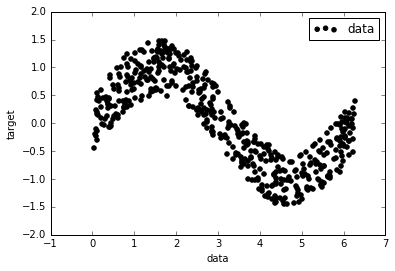

In [2]:
rng = np.random.RandomState(0)
train_size = 500
X = 2*np.pi * rng.rand(train_size, 1)
y = np.sin(X).ravel()

# Add noise to targets
spacing = 1
y[::spacing] += 1 * (0.5 - rng.rand(X.shape[0]//spacing))

# look at the results
plt.scatter(X, y, c='k', label='data')
plt.hold('on')
plt.xlabel('data')
plt.ylabel('target')
plt.legend()

#### Use GridSearchCV to find the best set of hyper-parameters using k-fold CV

In [3]:
# Fit regression model
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5, 
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)})
svr.fit(X[:train_size], y[:train_size])

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3], "gamma": np.logspace(-2, 2, 5)})
kr.fit(X[:train_size], y[:train_size])

sv_ratio = svr.best_estimator_.support_.shape[0] / train_size
print("Support vector ratio: %.3f" % sv_ratio)

Support vector ratio: 0.798


In [4]:
print svr.best_estimator_
print kr.best_estimator_

SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.10000000000000001, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)
KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=1.0, kernel='rbf',
      kernel_params=None)


### Validation curves

After having the optimal set of hyper-parameters for both KRR and SVR models, we will fix one and plot the validataion curve for $\gamma$. The curves show the average scores of the model as functions of $\gamma$, and the color bands show the std of the error estimates.

#### KRR

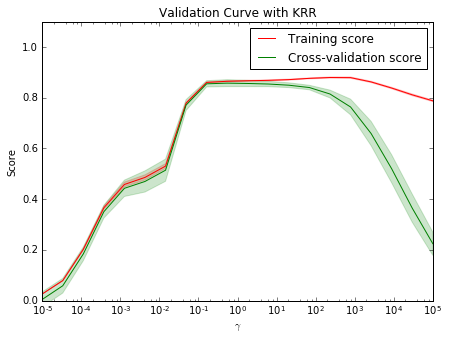

In [5]:
param_range=np.logspace(-5, 5, 20)
train_scores, test_scores = validation_curve(KernelRidge(kernel='rbf', alpha=kr.best_estimator_.alpha), X, y, 
                                             param_name="gamma", param_range=param_range, cv=6, n_jobs=4)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(7, 5))
plt.title("Validation Curve with KRR")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std, 
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

#### SVR

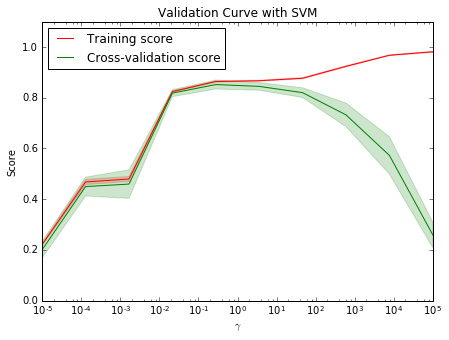

In [6]:
param_range=np.logspace(-5, 5, 10)
train_scores, test_scores = validation_curve(SVR(kernel='rbf', C=svr.best_estimator_.C), X[:train_size], y[:train_size], 
                                             param_name="gamma", param_range=param_range, cv=6, n_jobs=4)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(7, 5))
plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std, 
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

#### Comments: 
Both the validation curves follow the same behaviors: the score of the training and CV sets are both low for small $\gamma$, indicating the underfitting problem. At very high $\gamma$, the score of the training set is high, while that of the CV set is low. The optimal value of $\gamma$ is found somewhere in the middle range where the scores of both training and CV sets are reasonably high. 

## Classification

For classification problem, we will use Support Vector Classification (SVC)for the hand-written digits recognition. Similar to regression problems, we will plot the validation curve. The behavior of the model as a function of $\gamma$ is similar. It suffers the underfitting, archieves the trade-off and then suffers the over-fitting problem.

In [7]:
digits = load_digits()
X, y = digits.data, digits.target

In [8]:
from sklearn.svm import SVC
param_range = np.logspace(-6, -1, 20)
train_scores, test_scores = validation_curve(SVC(), X, y, param_name="gamma", param_range=param_range, 
                                             cv=6, scoring="accuracy", n_jobs=4)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

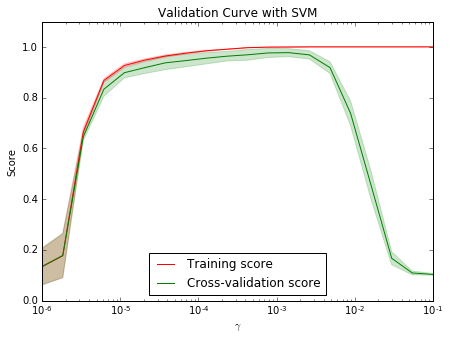

In [9]:
plt.figure(figsize=(7, 5))
plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std, 
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()